Modified from: https://github.com/GiacomoFabrini/Gel_Image_Analysis_1.0

In [1]:
# Import dependencies/libraries
import os 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [2]:
# This assumes the script is run within the following path of the datarepo: 
# "/Gels/DNA_templates/Protein_Capture_NS/"
filepath_45min = '45 min/Image_Inverted_Cropped.png' 
filepath_90min = '90 min/Image_Inverted_Cropped.png' 

In [3]:
def gel_analysis(
    filepath, num_lanes = 10, 
    crop = False, x1 = None, y1 = None, x2 = None, y2 = None, 
    in_offset = 50, fin_offset = 30, 
    shift = 10000, dimensions = (6, 10), 
    margin = 0, exclude = None
):
    # Inputs: 
    # -- filepath: filepath of the gel image to be analysed
    # -- num_lanes: number of lanes to be analysed in the gel - default is 10
    # -- crop, x1, y1, x2, y2: if crop = True, the image will be cropped between (x1, y1) and (x2, y2)
    # -- filepath: filepath of the gel image to be analysed
    # -- shift: automatic shifting between intensity profiles to be plotted (to avoid visual overlap)
    # -- dimensions: size of plotting figure
    # -- margin: margin from edges of cropped/uncropped gel image for automatic lane determination
    # -- exclude: list of lanes to be excluded from intensity profile plotting
    
    # This function returns a gel height array and a dictionary with the lane intensity profiles, which can 
    # be plotted againt the gel height array
    
    im = Image.open(filepath, 'r')
    # Cropping the image if crop == True - in that case the original image within the function is overwritten by
    # its cropped version
    if crop == False: 
        print('Image will not be cropped')
    elif (x1  == None) | (x2 == None) | (y1 == None) | (y2 == None): 
        print('Crop is set to True, but at least one of the box parameters is missing!')
    else: 
        im = im.crop((x1, y1, x2, y2))
        
    
    # Definition of some default parameters to center the lanes and extract their regions - semi-automatic
    sizes = im.size # size of the image
    in_offset = in_offset
    fin_offset = fin_offset # can be set to 50 like in_offset - these parameters can be tweaked, but they normally work well
    spacing = 40 # lane spacing
    width_lane = (sizes[0] - in_offset - fin_offset - (num_lanes-1)*spacing)/num_lanes # lane width
    pix_val = np.array(list(im.getdata())).reshape(-1) # this extracts a flat array of the pixel values
    cmap = plt.cm.get_cmap('jet')
    col_array = np.linspace(0,1, num_lanes)
    
    # Plotting the resulting lane selections, i.e. the loci where we are going to average the lanes (along x)
    # If this plot does not look right, the results will be messed up as well!
    print('Here is the resulting Lane Selection: ')
    plt.figure(figsize = (10, 5))
    plt.imshow(pix_val.reshape(sizes[1], sizes[0]), 'gray')
    for lane, index in zip(range(num_lanes), col_array):
        plt.vlines(in_offset + lane*width_lane + lane*spacing + margin/2, 0, im.size[1], cmap(index))
        plt.vlines(in_offset + (lane+1)*width_lane + lane*spacing - margin/2, 0, im.size[1], cmap(index))
    plt.show()
    
    # Plotting the resulting lane selections, i.e. the loci where we are going to average the lanes (along x)
    # If this plot does not look right, the results will be messed up as well! -- INVERTED IMAGE (black on white)
    print('Here is the resulting Lane Selection on the inverted gel image: ')
    plt.figure(figsize = (10, 5))
    plt.imshow(255 - pix_val.reshape(sizes[1], sizes[0]), 'gray')
    for lane, index in zip(range(num_lanes), col_array):
        plt.vlines(in_offset + lane*width_lane + lane*spacing + margin/2, 0, im.size[1], cmap(index))
        plt.vlines(in_offset + (lane+1)*width_lane + lane*spacing - margin/2, 0, im.size[1], cmap(index))
    plt.show()
        
    # Calculation/Extraction of Lane Intensity Profiles    
    profiles = {} # the actual profiles variable is a dictionary
    gel_hpx = np.linspace(0, im.size[1]-1, im.size[1]) # this is the gel height array
    for lane in range(num_lanes): 
        profiles[lane] = []
        lower_x = int(in_offset + lane*width_lane + lane*spacing + margin/2)
        upper_x = int(in_offset + (lane+1)*width_lane + lane*spacing - margin/2)
        for y in range(0, im.size[1]):
            # the intensity profile is simply the intensity along y averaged along x within each lane
            profiles[lane].append(np.average(pix_val.reshape(sizes[1], sizes[0])[y, lower_x:upper_x]))
    
    # Determining Samples in Lanes: labels by user input (tedious)
    labels = ['Lane ' + str(i+1) for i in range(num_lanes)]
    
    print('These are the resulting Lane Intensity Profiles: ')
    lane_list = np.arange(0, num_lanes, 1)
    if exclude != None: # exclude must be a tuple of the lanes you want to avoid
        lane_list = np.delete(lane_list, exclude)
    plt.figure(figsize = dimensions)
    for lane, index in zip(lane_list, col_array):
        plt.plot(gel_hpx, np.array(profiles[lane]) + int(shift*lane), color = cmap(index), label = labels[lane])

    plt.xlabel('Pixels (vertical)', fontsize = 20)
    plt.ylabel('Intensity [a.u.]', fontsize = 20)
    plt.legend(bbox_to_anchor = (1, 1), frameon = False, fontsize = 15)
    plt.show()
    return gel_hpx, profiles


# 45 min

Image will not be cropped
Here is the resulting Lane Selection: 


/var/folders/hm/4tf8_bk116sghbv11mksbw540000gn/T/ipykernel_3051/2301633619.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')


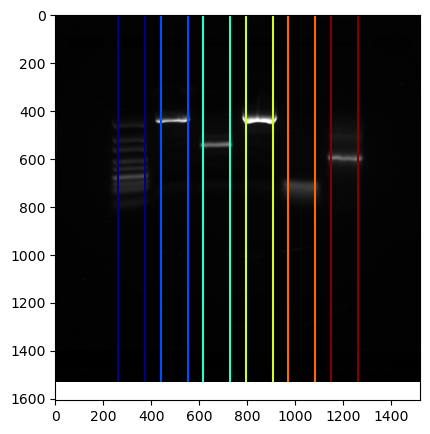

Here is the resulting Lane Selection on the inverted gel image: 


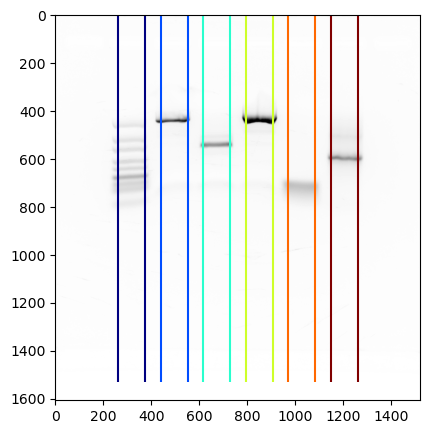

These are the resulting Lane Intensity Profiles: 


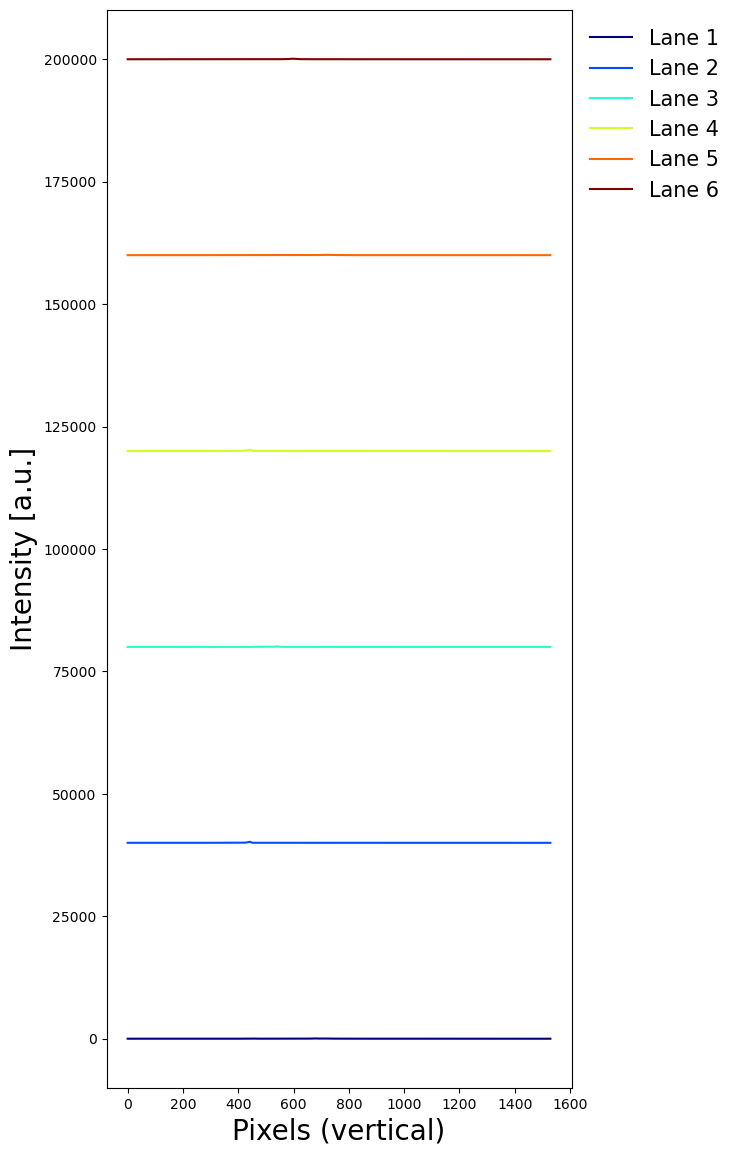

In [4]:
gel_hpx, profiles = gel_analysis(filepath_45min, num_lanes = 6, crop = False, x1 = 10, 
                                 y1 = 600, x2 = 1460, y2 = 1500, in_offset = 250, fin_offset = 250, shift = 40000, dimensions = (6, 14), margin = 25)

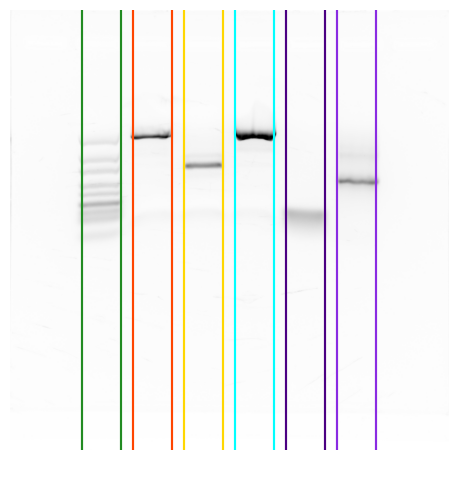

In [5]:
# This bit of code reuses the parameters for cropping (see above) and plots nice lane boundaries
im = Image.open(filepath_45min, 'r')
#im = im.crop((520, 600, 1460, 1400))
plt.figure(figsize = (6, 6))
plt.imshow(im, 'gray')
plt.axis('off')

margin = 0
in_offset = 250

fin_offset = 250
spacing = 40 # lane spacing
num_lanes = 6
col_array = np.arange(0, num_lanes, 1)
colours = ['forestgreen', 'orangered', 'gold', 'cyan', 'indigo', 'blueviolet']
alphas = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

sizes = im.size
width_lane = (sizes[0] - in_offset - fin_offset - (num_lanes-1)*spacing)/num_lanes # lane width

linew = 1.5

for lane, index in zip(range(num_lanes), col_array):
    plt.vlines(in_offset + lane*width_lane + lane*spacing + margin/2, 0, im.size[1], color = colours[int(index)], alpha = alphas[int(index)], linewidth = linew)
    plt.vlines(in_offset + lane*width_lane + lane*spacing + margin/2, 0, im.size[1], color = colours[int(index)], alpha = alphas[int(index)], linewidth = linew)
    plt.vlines(in_offset + (lane+1)*width_lane + lane*spacing - margin/2, 0, im.size[1], color = colours[int(index)], alpha = alphas[int(index)], linewidth = linew)
    plt.vlines(in_offset + (lane+1)*width_lane + lane*spacing - margin/2, 0, im.size[1], color = colours[int(index)], alpha = alphas[int(index)], linewidth = linew)

# Re-enable to save image in SVG format
# plt.savefig('DNA_templates_proteincapture_lanes_45min.svg')

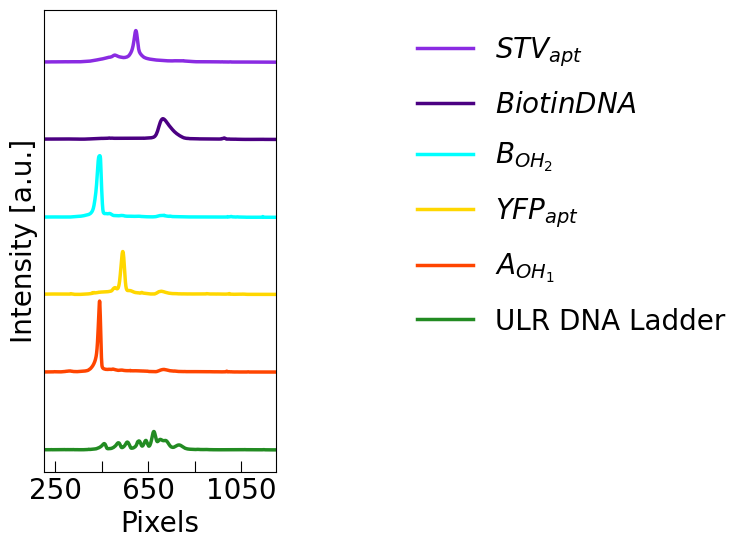

In [6]:
spac = 0.025
plt.figure(figsize = (3, 6))

# ULR Ladder
plt.plot(gel_hpx[200:], 
         np.array(profiles[0])[200:]/np.trapz(np.array(profiles[0])[200:], gel_hpx[200:]), 
         color = colours[0], linewidth = 2.5, label = 'ULR DNA Ladder')
# Sample 1
plt.plot(gel_hpx[200:], 
         np.array(profiles[1])[200:]/np.trapz(np.array(profiles[1])[200:], gel_hpx[200:]) + spac, 
         color = colours[1], linewidth = 2.5,label = r'$A_{OH_1}$')
# Sample 2
plt.plot(gel_hpx[200:], 
         np.array(profiles[2])[200:]/np.trapz(np.array(profiles[2])[200:], gel_hpx[200:]) + 2*spac, 
         color = colours[2], linewidth = 2.5, label = r'$YFP_{apt}$')
# Sample 3
plt.plot(gel_hpx[200:],
         np.array(profiles[3])[200:]/np.trapz(np.array(profiles[3])[200:], gel_hpx[200:]) + 3*spac, 
         color = colours[3], linewidth = 2.5, label = r'$B_{OH_2}$')
# Sample 4
plt.plot(gel_hpx[200:], 
         np.array(profiles[4])[200:]/np.trapz(np.array(profiles[4])[200:], gel_hpx[200:]) + 4*spac, 
         color = colours[4], linewidth = 2.5, label = r'$Biotin DNA$')
# Sample 5
plt.plot(gel_hpx[200:], 
         np.array(profiles[5])[200:]/np.trapz(np.array(profiles[5])[200:], gel_hpx[200:]) + 5*spac, 
         color = colours[5], linewidth = 2.5, label = r'$STV_{apt}$')


plt.xticks([250, 450, 650, 850, 1050, 1250, 1450], [250, '', 650, '', 1050, '', 1450], fontsize = 20)
plt.yticks([], [])
plt.xlabel('Pixels', fontsize = 20)
plt.ylabel('Intensity [a.u.]', fontsize = 20)
plt.xlim([200, 1200])
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles[::-1], 
    labels[::-1], 
    ncol=1, 
    fontsize=20, 
    labelspacing=0.8, 
    frameon=False, 
    bbox_to_anchor=[1.5, 1]
)
ax.tick_params(direction = 'in', length = 8)
# Re-enable to save image in SVG format
# plt.savefig('DNA_templates_proteincapture_lane_profiles_45min.svg', bbox_inches = 'tight')

# 90 min

Image will not be cropped
Here is the resulting Lane Selection: 


/var/folders/hm/4tf8_bk116sghbv11mksbw540000gn/T/ipykernel_3051/2301633619.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')


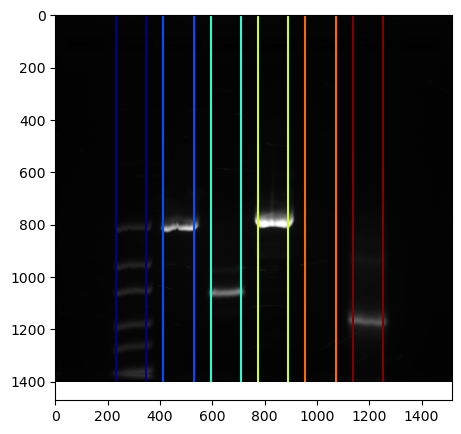

Here is the resulting Lane Selection on the inverted gel image: 


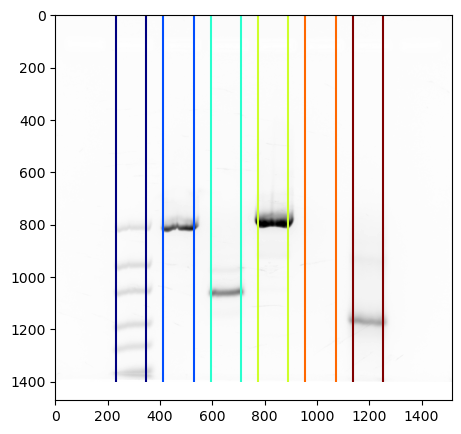

These are the resulting Lane Intensity Profiles: 


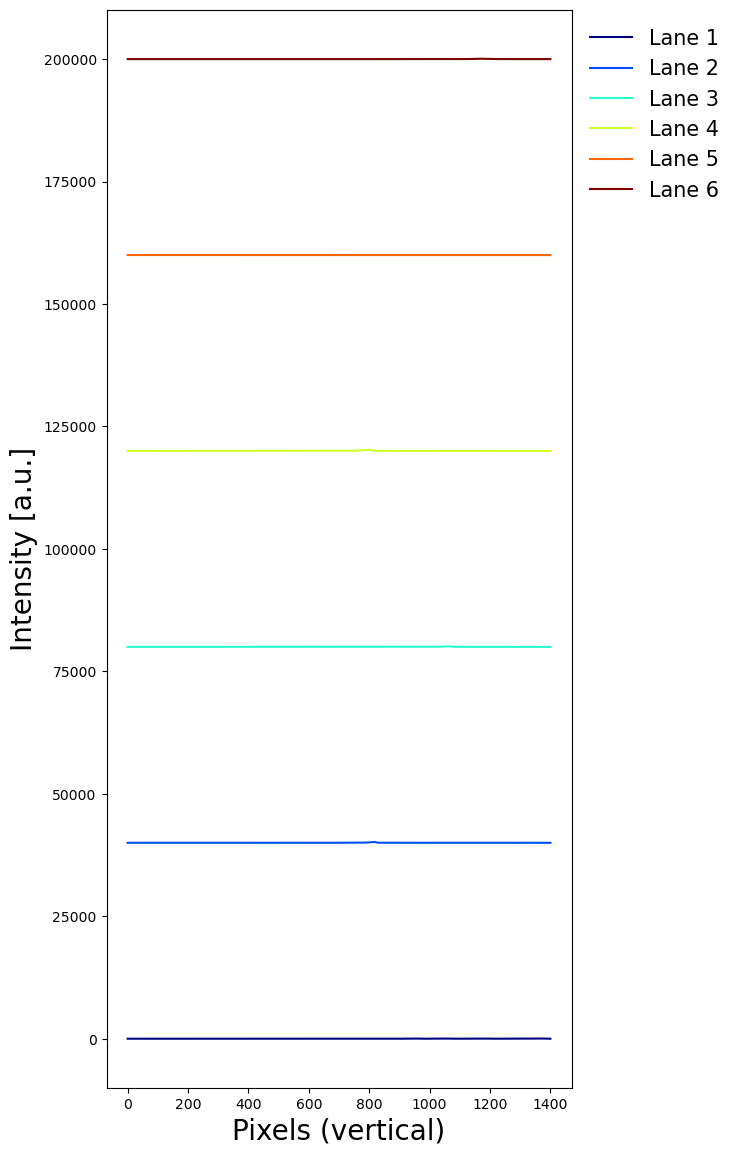

In [7]:
gel_hpx, profiles = gel_analysis(filepath_90min, num_lanes = 6, crop = False, x1 = 10, 
                                 y1 = 600, x2 = 1460, y2 = 1500, in_offset = 220, fin_offset = 250, shift = 40000, dimensions = (6, 14), margin = 25)

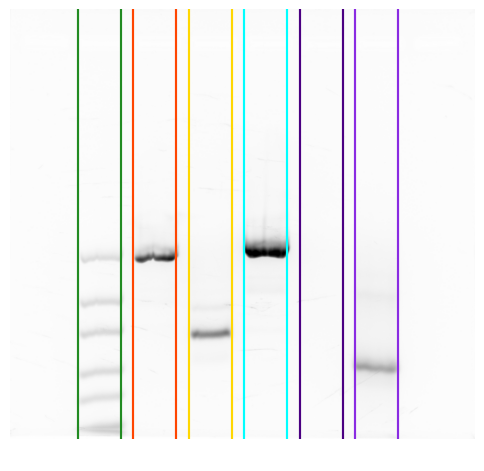

In [8]:
# This bit of code reuses the parameters for cropping (see above) and plots nice lane boundaries
im = Image.open(filepath_90min, 'r')
#im = im.crop((520, 600, 1460, 1400))
plt.figure(figsize = (6, 6))
plt.imshow(im, 'gray')
plt.axis('off')

margin = 0
in_offset = 220

fin_offset = 250
spacing = 40 # lane spacing
num_lanes = 6
col_array = np.arange(0, num_lanes, 1)
colours = ['forestgreen', 'orangered', 'gold', 'cyan', 'indigo', 'blueviolet']
alphas = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

sizes = im.size
width_lane = (sizes[0] - in_offset - fin_offset - (num_lanes-1)*spacing)/num_lanes # lane width

linew = 1.5

for lane, index in zip(range(num_lanes), col_array):
    plt.vlines(in_offset + lane*width_lane + lane*spacing + margin/2, 0, im.size[1], color = colours[int(index)], alpha = alphas[int(index)], linewidth = linew)
    plt.vlines(in_offset + lane*width_lane + lane*spacing + margin/2, 0, im.size[1], color = colours[int(index)], alpha = alphas[int(index)], linewidth = linew)
    plt.vlines(in_offset + (lane+1)*width_lane + lane*spacing - margin/2, 0, im.size[1], color = colours[int(index)], alpha = alphas[int(index)], linewidth = linew)
    plt.vlines(in_offset + (lane+1)*width_lane + lane*spacing - margin/2, 0, im.size[1], color = colours[int(index)], alpha = alphas[int(index)], linewidth = linew)

# Re-enable to save image in SVG format 
# plt.savefig('DNA_templates_proteincapture_lanes_90min.svg')

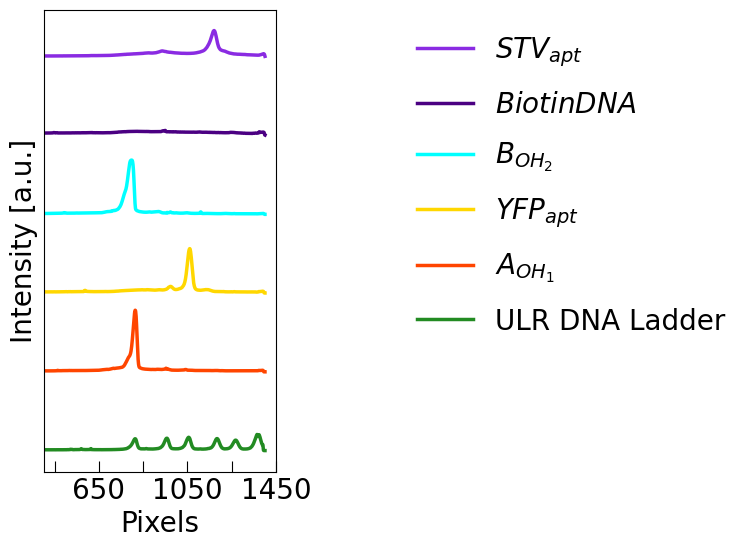

In [9]:
spac = 0.02
plt.figure(figsize = (3, 6))

# ULR Ladder
plt.plot(gel_hpx[200:], 
         np.array(profiles[0])[200:]/np.trapz(np.array(profiles[0])[200:], gel_hpx[200:]), 
         color = colours[0], linewidth = 2.5, label = 'ULR DNA Ladder')
# Sample 1
plt.plot(gel_hpx[200:], 
         np.array(profiles[1])[200:]/np.trapz(np.array(profiles[1])[200:], gel_hpx[200:]) + spac, 
         color = colours[1], linewidth = 2.5,label = r'$A_{OH_1}$')
# Sample 2
plt.plot(gel_hpx[200:], 
         np.array(profiles[2])[200:]/np.trapz(np.array(profiles[2])[200:], gel_hpx[200:]) + 2*spac, 
         color = colours[2], linewidth = 2.5, label = r'$YFP_{apt}$')
# Sample 3
plt.plot(gel_hpx[200:],
         np.array(profiles[3])[200:]/np.trapz(np.array(profiles[3])[200:], gel_hpx[200:]) + 3*spac, 
         color = colours[3], linewidth = 2.5, label = r'$B_{OH_2}$')
# Sample 4
plt.plot(gel_hpx[200:], 
         np.array(profiles[4])[200:]/np.trapz(np.array(profiles[4])[200:], gel_hpx[200:]) + 4*spac, 
         color = colours[4], linewidth = 2.5, label = r'$Biotin DNA$')
# Sample 5
plt.plot(gel_hpx[200:], 
         np.array(profiles[5])[200:]/np.trapz(np.array(profiles[5])[200:], gel_hpx[200:]) + 5*spac, 
         color = colours[5], linewidth = 2.5, label = r'$STV_{apt}$')


plt.xticks([250, 450, 650, 850, 1050, 1250, 1450], [250, '', 650, '', 1050, '', 1450], fontsize = 20)
plt.yticks([], [])
plt.xlabel('Pixels', fontsize = 20)
plt.ylabel('Intensity [a.u.]', fontsize = 20)
plt.xlim([400, 1450])
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles[::-1], 
    labels[::-1], 
    ncol=1, 
    fontsize=20, 
    labelspacing=0.8, 
    frameon=False, 
    bbox_to_anchor=[1.5, 1]
)
ax.tick_params(direction = 'in', length = 8)
# Re-enable to save image in SVG format
# plt.savefig('DNA_templates_proteincapture_lane_profiles_90min.svg', bbox_inches = 'tight')